In [ ]:
#voc格式目标检测数据
#!unzip data/data76481/VOC2008.zip -d masks

In [1]:
# 准备一些可能用到的工具库
import xml.etree.cElementTree as ET
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import paddle.fluid as fluid
import time
import random

# 通过paddlex划分数据集

In [2]:
!pip install paddlex

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 522kB 14.3MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 14.3MB/s eta 0:00:01
     |████████████████████████████████| 153kB 20.0MB/s eta 0:00:01
     |████████████████████████████████| 102kB 25.9MB/s ta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=278370 sha256=b394a1f4d5560e3342cc6b47338e669382533a34c7f8b486862626d5f4c0d545
  Stored in directory: /home/aistudio/.cache/pip/wheels/fb/44/67/8baa69040569b1edbd7776ec6f82c387663e724908aaa60963
Successfully built pycocotools


In [4]:
!paddlex --split_dataset --format VOC --dataset_dir masks/VOC2008 --val_value 0.2 --test_value 0.1

Dataset Split Done.
Train samples: 85
Eval samples: 23
Test samples: 11
Split files saved in masks/VOC2008


# 下载PaddleDetection并部署环境，修改数据集路径

In [ ]:
!git clone https://gitee.com/paddlepaddle/PaddleDetection.git

Cloning into 'PaddleDetection'...
remote: Enumerating objects: 11219, done.
remote: Counting objects: 100% (11219/11219), done.
remote: Compressing objects: 100% (5914/5914), done.
remote: Total 11219 (delta 8180), reused 7297 (delta 5179), pack-reused 0
Receiving objects: 100% (11219/11219), 56.01 MiB | 5.09 MiB/s, done.
Resolving deltas: 100% (8180/8180), done.
Checking connectivity... done.


In [ ]:
!cd PaddleDetection && git branch release/0.5

In [5]:
#配置PaddleDetection环境
!pip install -r PaddleDetection/requirements.txt

Looking in indexes: https://mirror.baidu.com/pypi/simple/


In [ ]:
# 把PaddleDetection送到work目录下，可以持久保存
!mv PaddleDetection work/

In [ ]:
#将数据集转到PaddleDetection/dataset，专门存放和处理数据集的文件
!cp -r masks/VOC2008 work/PaddleDetection/dataset/

In [7]:
%cd work/PaddleDetection

/home/aistudio/work/PaddleDetection


In [ ]:
# 调整下标注文件命名，与PaddleDetection默认的一致（处理成相同文件名）
!mv dataset/VOC2008/labels.txt dataset/VOC2008/label_list.txt

# 修改模型文件ssd_vgg16_300_voc.yml
地址：work/PaddleDetection/configs/ssd/ssd_vgg16_300_voc.yml

新手所需修改部分：（修改后可以跑通，若想提高精度需要细调）
```
max_iters: 132
# max_iters=训练集格式*迭代次数/batch_size
```
```
num_classes: 3
# 20(label_class) + 1(background)
```
TrainReader、EvalReader、TestReader中的数据集地址
```
dataset_dir: dataset/VOC2008
anno_path: train_list.txt
use_default_label: false
```
```
anno_path: val_list.txt
dataset_dir: dataset/VOC2008
use_default_label: false
```
```
anno_path: dataset/VOC2008/test_list.txt
use_default_label: false
```

全部代码（可直接复制，建议去官方文档看看参数含义）

官方文档：[https://paddledetection.readthedocs.io/](http://)

github链接：[https://github.com/PaddlePaddle/PaddleDetection](http://)
```
architecture: SSD
use_gpu: true
max_iters: 132
# max_iters=训练集格式*迭代次数/batch_size
snapshot_iter: 10000
log_iter: 10
metric: VOC
map_type: 11point
pretrain_weights: https://paddle-imagenet-models-name.bj.bcebos.com/VGG16_caffe_pretrained.tar
save_dir: output
weights: output/ssd_vgg16_300_voc/model_final
# 20(label_class) + 1(background)
num_classes: 3

SSD:
  backbone: VGG
  multi_box_head: MultiBoxHead
  output_decoder:
    background_label: 0
    keep_top_k: 200
    nms_eta: 1.0
    nms_threshold: 0.45
    nms_top_k: 400
    score_threshold: 0.01

VGG:
  depth: 16
  with_extra_blocks: true
  normalizations: [20., -1, -1, -1, -1, -1]

MultiBoxHead:
  base_size: 300
  aspect_ratios: [[2.], [2., 3.], [2., 3.], [2., 3.], [2.], [2.]]
  min_ratio: 20
  max_ratio: 90
  min_sizes: [30.0, 60.0, 111.0, 162.0, 213.0, 264.0]
  max_sizes: [60.0, 111.0, 162.0, 213.0, 264.0, 315.0]
  steps: [8, 16, 32, 64, 100, 300]
  offset: 0.5
  flip: true
  min_max_aspect_ratios_order: true
  kernel_size: 3
  pad: 1

LearningRate:
  base_lr: 0.001
  schedulers:
  - !PiecewiseDecay
    gamma: 0.1
    milestones: [80000, 100000]

OptimizerBuilder:
  optimizer:
    momentum: 0.9
    type: Momentum
  regularizer:
    factor: 0.0005
    type: L2

TrainReader:
  inputs_def:
    image_shape: [3, 300, 300]
    fields: ['image', 'gt_bbox', 'gt_class']
  dataset:
    !VOCDataSet
    dataset_dir: dataset/VOC2008
    anno_path: train_list.txt
    use_default_label: false
  sample_transforms:
  - !DecodeImage
    to_rgb: true
  - !RandomDistort
    brightness_lower: 0.875
    brightness_upper: 1.125
    is_order: true
  - !RandomExpand
    fill_value: [104, 117, 123]
  - !RandomCrop
    allow_no_crop: true
  - !NormalizeBox {}
  - !ResizeImage
    interp: 1
    target_size: 300
    use_cv2: false
  - !RandomFlipImage
    is_normalized: true
  - !Permute
    to_bgr: false
  - !NormalizeImage
    is_scale: false
    mean: [104, 117, 123]
    std: [1, 1, 1]
  batch_size: 8
  shuffle: true
  worker_num: 8
  bufsize: 16
  use_process: true

EvalReader:
  inputs_def:
    image_shape: [3, 300, 300]
    fields: ['image', 'gt_bbox', 'gt_class', 'im_shape', 'im_id', 'is_difficult']
  dataset:
    !VOCDataSet
    anno_path: val_list.txt
    dataset_dir: dataset/VOC2008
    use_default_label: false
  sample_transforms:
  - !DecodeImage
    to_rgb: true
    with_mixup: false
  - !NormalizeBox {}
  - !ResizeImage
    interp: 1
    target_size: 300
    use_cv2: false
  - !Permute
    to_bgr: false
  - !NormalizeImage
    is_scale: false
    mean: [104, 117, 123]
    std: [1, 1, 1]
  batch_size: 32
  worker_num: 8
  bufsize: 16

TestReader:
  inputs_def:
    image_shape: [3,300,300]
    fields: ['image', 'im_id', 'im_shape']
  dataset:
    !ImageFolder
    anno_path: dataset/VOC2008/test_list.txt
    use_default_label: false
  sample_transforms:
  - !DecodeImage
    to_rgb: true
    with_mixup: false
  - !ResizeImage
    interp: 1
    max_size: 0
    target_size: 300
    use_cv2: true
  - !Permute
    to_bgr: false
  - !NormalizeImage
    is_scale: false
    mean: [104, 117, 123]
    std: [1, 1, 1]
  batch_size: 1
```

# 模型训练

In [9]:
# 配置文件在work/PaddleDetection/configs/ssd/ssd_vgg16_300_voc.yml，模型保存在work/PaddleDetection/output
# 可使用可视化工具VisualDL,文件在work/PaddleDetection/vdl_log_dir（需要模型运行时才能产出）
!python -u tools/train.py -c configs/ssd/ssd_vgg16_300_voc.yml --use_vdl True --eval

W0329 13:51:28.574571  1532 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 11.0, Runtime API Version: 9.0
W0329 13:51:28.580085  1532 device_context.cc:260] device: 0, cuDNN Version: 7.6.
2021-03-29 13:51:30,794-WARNING: /home/aistudio/.cache/paddle/weights/VGG16_caffe_pretrained.pdparams not found, try to load model file saved with [ save_params, save_persistables, save_vars ]
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/io.py:1998: UserWarning: This list is not set, Because of Paramerter not found in program. There are: fc8_weights fc8_biases
  format(" ".join(unused_para_list)))
2021-03-29 13:51:39,256-INFO: iter: 0, lr: 0.001000, 'loss': '19.797258', eta: 0:01:33, batch_cost: 0.08786 sec, ips: 91.05483 images/sec
[INFO 2021-03-29 13:51:39,256 train.py:286] iter: 0, lr: 0.001000, 'loss': '19.797258', eta: 0:01:33, batch_cost: 0.08786 sec, ips: 91.05483 images/sec
2021-03-29 13:51:40,831-INFO: iter: 10, lr: 0

# 模型预测

In [34]:
#测试，查看模型效果，结果存放在work/PaddleDetection/output
%cd /home/aistudio/work/PaddleDetection/
!python tools/infer.py -c configs/ssd/ssd_vgg16_300_voc.yml --infer_img=/home/aistudio/001.jpg

/home/aistudio/work/PaddleDetection
W0329 14:26:00.744035  3395 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 11.0, Runtime API Version: 9.0
W0329 14:26:00.748915  3395 device_context.cc:260] device: 0, cuDNN Version: 7.6.
2021-03-29 14:26:03,975-INFO: Load categories from dataset/VOC2008/test_list.txt
2021-03-29 14:26:04,158-INFO: Infer iter 0
2021-03-29 14:26:04,167-INFO: Detection bbox results save in output/001.jpg


In [35]:
%cd /home/aistudio/

/home/aistudio


In [36]:
import matplotlib.pyplot as plt
import PIL.Image as Image

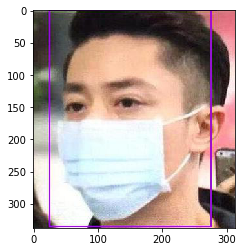

In [38]:
path='work/PaddleDetection/output/001.jpg'
img = Image.open(path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像

# 导出模型进行部署

In [2]:
# 导出模型
%cd /home/aistudio/work/PaddleDetection/
!python tools/export_model.py -c configs/ssd/ssd_vgg16_300_voc.yml -o weights=output/ssd_vgg16_300_voc/model_final.pdparams --output_dir ./inference

/home/aistudio/work/PaddleDetection
2021-03-29 14:31:57,499-INFO: Load categories from dataset/VOC2008/test_list.txt
2021-03-29 14:31:57,506-INFO: Export inference config file to ./inference/ssd_vgg16_300_voc/infer_cfg.yml
2021-03-29 14:31:57,536-INFO: save_inference_model pruned unused feed variables im_id
2021-03-29 14:31:57,537-INFO: save_inference_model pruned unused feed variables im_shape
2021-03-29 14:31:57,537-INFO: Export inference model to ./inference/ssd_vgg16_300_voc, input: ['image'], output: ['detection_output_0.tmp_0']...


In [4]:
#导入paddleList（模型部署依赖包）
!pip install paddlelite==2.6.3

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 42.8MB 5.0MB/s eta 0:00:013     |███████████████████████████████▊| 42.4MB 5.0MB/s eta 0:00:01


In [6]:
# 准备PaddleLite部署模型
# 生成文件存储在work/PaddleDetection/inference
!paddle_lite_opt \
    --model_file=inference/ssd_vgg16_300_voc/__model__ \
    --param_file=inference/ssd_vgg16_300_voc/__params__ \
    --optimize_out=./inference/ssd_vgg16_300_voc \
    --optimize_out_type=naive_buffer \
    --valid_targets=arm 

I0329 14:36:57.619174  3867 cxx_api.cc:254] Load model from file.
I0329 14:36:57.743980  3867 optimizer.h:232] == Running pass: lite_quant_dequant_fuse_pass
I0329 14:36:57.748384  3867 optimizer.h:256] == Finished running: lite_quant_dequant_fuse_pass
I0329 14:36:57.748400  3867 optimizer.h:232] == Running pass: weight_quantization_preprocess_pass
I0329 14:36:57.748519  3867 optimizer.h:256] == Finished running: weight_quantization_preprocess_pass
I0329 14:36:57.748529  3867 optimizer.h:232] == Running pass: lite_conv_elementwise_fuse_pass
I0329 14:36:57.753765  3867 pattern_matcher.cc:108] detected 35 subgraph
I0329 14:36:57.754854  3867 optimizer.h:256] == Finished running: lite_conv_elementwise_fuse_pass
I0329 14:36:57.754873  3867 optimizer.h:232] == Running pass: lite_conv_bn_fuse_pass
I0329 14:36:57.757824  3867 optimizer.h:256] == Finished running: lite_conv_bn_fuse_pass
I0329 14:36:57.757836  3867 optimizer.h:232] == Running pass: lite_conv_elementwise_fuse_pass
I0329 14:36:57.

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 